In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import tensorflow as tf
import datetime

In [3]:
#Directory:
dataset_dir = r'D:\kelaswork\jupyterlab\animals'
test_dir = r'D:\kelaswork\jupyterlab\test_animals'

In [4]:
# ImageDataGenerator with split validation
datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.1,validation_split=0.1,fill_mode='nearest', rotation_range=30 )
datagen_test = ImageDataGenerator(rescale=1./255,zoom_range=0.1,fill_mode='nearest', rotation_range=30)

# Generator for training
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

#Generator for validasi
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  
)
                 

#Generator for test
test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical' 
)

Found 584 images belonging to 4 classes.
Found 64 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [5]:
class_indices = train_generator.class_indices
print(class_indices)

{'cheetah': 0, 'leopard': 1, 'lion': 2, 'tiger': 3}


In [6]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print(f"Number of layers in base model: {len(base_model.layers)}")

Number of layers in base model: 19


In [7]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model_checkpoint = ModelCheckpoint(
    'best_model.keras',     # Nama file tempat menyimpan model
    monitor='val_accuracy', # Monitor metric yang diinginkan, misalnya val_accuracy
    save_best_only=True,    # Hanya menyimpan model terbaik
    mode='max'              # Mode 'max' karena kita ingin akurasi tertinggi
)

# Callback untuk early stopping berdasarkan val_loss
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor metric yang diinginkan, misalnya val_loss
    patience=10,                # Berhenti setelah 10 epoch tanpa peningkatan
    restore_best_weights=True   # Mengembalikan bobot terbaik yang ditemukan
)

# Callback untuk mengurangi learning rate ketika val_loss berhenti meningkat
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1
)

# Callback untuk mencatat informasi selama pelatihan model
tensorboard = TensorBoard(
    log_dir='./logs',
    update_freq='epoch'
)

# Daftar callback


In [10]:
callbacks = [model_checkpoint, early_stopping, reduce_lr, tensorboard]

In [11]:
model = Sequential([
    base_model,
    Conv2D(8, (3, 3), activation='relu', padding='SAME'), 
    MaxPooling2D((2,2),padding='same'),
    Conv2D(16, (3, 3), activation='relu',padding='SAME'),
    MaxPooling2D((2,2),padding='same'),
    Conv2D(32, (3, 3), activation='relu',padding='SAME'),
    MaxPooling2D((2,2),padding='same'),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')
])

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
# history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callbacks)

In [15]:
history = model.fit(train_generator,  epochs=40,validation_data=val_generator, callbacks=callbacks)

Epoch 1/40


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 870s 44s/step - accuracy: 0.2581 - loss: 1.3847 - val_accuracy: 0.4844 - val_loss: 1.2634 - learning_rate: 0.0010
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 942s 48s/step - accuracy: 0.5067 - loss: 1.1930 - val_accuracy: 0.7344 - val_loss: 0.7348 - learning_rate: 0.0010
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 890s 46s/step - accuracy: 0.6783 - loss: 0.7257 - val_accuracy: 0.6719 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 1252s 65s/step - accuracy: 0.6822 - loss: 0.6955 - val_accuracy: 0.7031 - val_loss: 0.4444 - learning_rate: 0.0010
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 982s 53s/step - accuracy: 0.7356 - loss: 0.5424 - val_accuracy: 0.7656 - val_loss: 0.4024 - learning_rate: 0.0010
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 1025s 53s/step - accuracy: 0.7106 - loss: 0.5763 - val_accuracy: 0.7344 - val_loss: 0.5173 - learning_rate: 0.0010
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 877s 45s/step - accuracy: 0.7892 - loss: 0.4243 - val_accur

In [16]:
model.save('saved_model.keras')

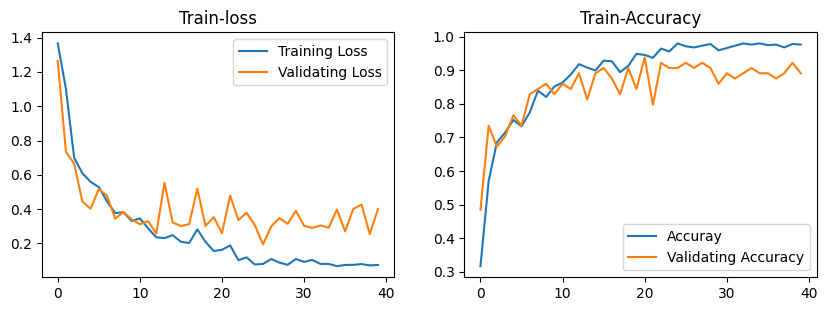

In [17]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label= 'Training Loss')
plt.plot(history.history['val_loss'],label= 'Validating Loss')
plt.title('Train-loss')
plt.legend()
plt.savefig('10.jpg')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'],label= 'Accuray')
plt.plot(history.history['val_accuracy'],label= 'Validating Accuracy')
plt.title('Train-Accuracy')
plt.legend()
plt.savefig('11.jpg')

In [18]:
model.save('saved_model_directory.keras')

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)

# Print hasil evaluasi
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 93s 25s/step - accuracy: 0.8160 - loss: 0.6572
Test Loss: 0.6519275307655334
Test Accuracy: 0.8194444179534912


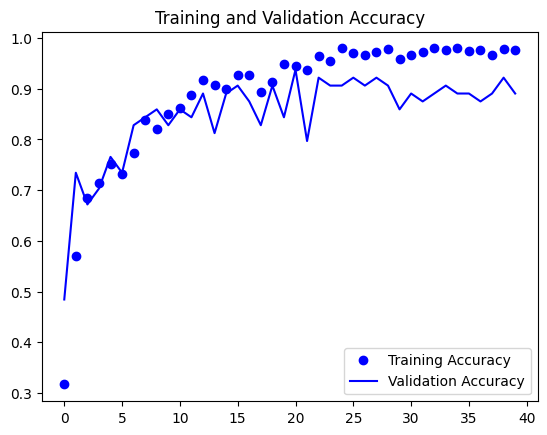

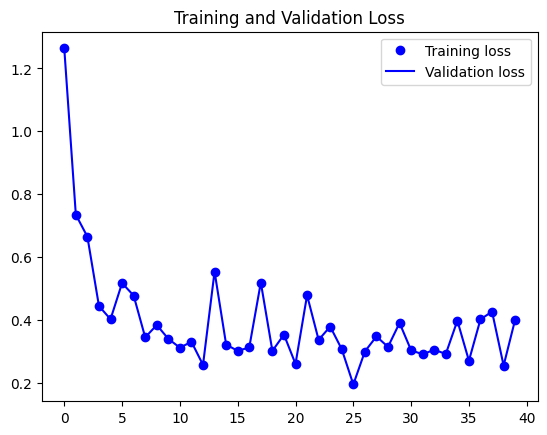

In [20]:
#Result
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['val_loss']
val_loss = history.history['val_loss']
ephocs= range(len(accuracy))
plt.plot(ephocs, accuracy,'bo', label='Training Accuracy')
plt.plot(ephocs, val_accuracy,'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('14.jpg')
plt.figure()
plt.plot(ephocs, loss,'bo', label='Training loss')
plt.plot(ephocs, val_loss,'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('13.jpg')

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np